In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import os
from tqdm.auto import tqdm
from glob import glob
import cv2
import numpy as np
import pandas as pd
import PIL 
import urllib
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from random import uniform
from imgaug import augmenters as iaa

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# pip install monai

In [3]:
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib

In [4]:
import torch.utils.data as td
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt
import time
from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)

In [5]:
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
)

In [6]:
# !pip install pydicom

In [7]:
import pydicom as dcm

전처리


*   https://github.com/tuvovan/Unet-with-EfficientnetB7-Backbone/blob/master/Body%20Morphometry.ipynb


모델


*   https://github.com/IanTaehoonYoo/semantic-segmentation-pytorch




In [8]:
import glob
data_path=sorted(glob.glob( "../input/body-morphometry-kidney-and-tumor/train/DICOM/**/*.dcm",recursive=True ))
label_path=sorted(glob.glob("../input/body-morphometry-kidney-and-tumor/train/Label/**/*.png",recursive = True))

In [9]:
from skimage.transform import resize
from skimage.io import imread
from tensorflow.keras.preprocessing.image import load_img
import numpy as np
import pydicom

def transform_to_hu(medical_image, image):
    hu_image = image *1 + 0
    hu_image[hu_image < -1024] = -1024
    return hu_image

def window_image(image, window_center, window_width):
    window_image = image.copy()
    image_min = window_center - (window_width / 2)
    image_max = window_center + (window_width / 2)
    window_image[window_image < image_min] = image_min
    window_image[window_image > image_max] = image_max
    return window_image

def resize_normalize(image):
    image = np.array(image, dtype=np.float32)
    image -= np.min(image)
    image /= np.max(image)
    return image

def read_dicom(image_medical, window_widht, window_level):
    img3d_input = np.zeros([512,512,size])
#     img3d_input = np.zeros([512,512,64])
    for i in range(size):
        image_data = image_medical[i].pixel_array

        image_hu = transform_to_hu(image_medical, image_data)
#         image_window = window_image(image_hu.copy(), window_level, window_widht)
#         image_window_norm = resize_normalize(image_window)
        #     image_window_norm = image_window

#         image_window_norm = np.expand_dims(image_window_norm, axis=2)   # (512, 512, 1)
#         image_ths = np.concatenate([image_window_norm, image_window_norm, image_window_norm], axis=2)   # (512, 512, 3)

        img3d_input[:,:,i] = image_hu

    return img3d_input

def to_binary(img, lower, upper):
    return (lower <= img) & (img <= upper)

In [10]:
os.mkdir('./input_data')
os.mkdir('./input_label')

In [11]:
cnt=0
size=64
na =0

for c in tqdm(range(100)):
    
    for k in range(int(64/size)):
        input_d=[]
        label_d=[]
        input_p = data_path[cnt:cnt+size]
        label_p = label_path[cnt:cnt+size]
        
        for i in range(size):
            read = dcm.read_file(input_p[i])
            input_d.append(read)

            y_img=imread(label_p[i])
#             y_img=y_img.astype(np.float32)
            label_d.append(y_img)

#         print(len(label_d))
        np.save(f'./input_data/train_0{na}', input_d)
        np.save(f'./input_label/label_0{na}', label_d)
        na+=1
         
    
    cnt = cnt+size

  0%|          | 0/100 [00:00<?, ?it/s]

In [12]:
def mask_binarization(mask, threshold=None):
    if threshold is None:
        threshold = 0.5

    if isinstance(mask, np.ndarray):
        mask_binarized = (mask > threshold).astype(np.uint8)
    
    elif isinstance(mask, torch.Tensor):
        zeros = torch.zeros_like(mask)
        ones = torch.ones_like(mask)
        
        mask_binarized = torch.where(mask > threshold, ones, zeros)
    
    return mask_binarized

def augment_imgs_and_masks(imgs, masks, rot_factor, scale_factor, trans_factor, flip):
    rot_factor = uniform(-rot_factor, rot_factor)
    ran_alp = uniform(10,100)
    scale_factor = uniform(1-scale_factor, 1+scale_factor)
    trans_factor = [int(imgs.shape[1]*uniform(-trans_factor, trans_factor)),
                    int(imgs.shape[2]*uniform(-trans_factor, trans_factor))]

    seq = iaa.Sequential([
            iaa.Affine(
                translate_px={"x": trans_factor[0], "y": trans_factor[1]},
                scale=(scale_factor, scale_factor),
                rotate=rot_factor
            ),
            iaa.ElasticTransformation(alpha=ran_alp,sigma=5.0,mode='constant')
        
        ])

    seq_det = seq.to_deterministic()

    imgs = seq_det.augment_images(imgs)
    masks = seq_det.augment_images(masks)

    if flip and uniform(0, 1) > 0.5:
        imgs = np.flip(imgs, 2).copy()
        masks = np.flip(masks, 2).copy()
    
    masks = mask_binarization(masks).astype(np.float32)
    return imgs, masks

In [16]:
size=64

In [13]:
aug = Compose(
    [
#         LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-100,
            a_max=300,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
#         Rand3DElastic(
#     prob=1.0,
#     spacing=(30, 30),
#     magnitude_range=(5, 6),
#     rotate_range=(np.pi / 4,),
#     scale_range=(0.2, 0.2),
#     translate_range=(100, 100),
#     padding_mode="zeros",
#     device=torch.device("cuda:0"),
# ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(192, 192, 32),
            pos=1,
            neg=1,
            num_samples=3,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
        ToTensord(keys=["image", "label"]),
    ]
)
test_transforms = Compose(
    [
#         LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-100, a_max=300, b_min=0.0, b_max=1.0, clip=True
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)

In [14]:
# Data augmentation
import random
rot_factor = 30. 
scale_factor = 0.15
flip = True
trans_factor = 0.1

In [15]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, x_dir, y_dir, transform=aug):
        super().__init__()
        global data_root, w_min, w_max, crop_size, input_size, rot_factor, scale_factor, trans_factor, flip

        self.transforms = transform
        # self.augmentation = augmentation
        self.x_img = x_dir
        self.y_img = y_dir   

    def __len__(self):
        return len(self.x_img)

    def __getitem__(self, idx):
        x_img = self.x_img[idx]
        y_img = self.y_img[idx]
        x_img = np.load(x_img, allow_pickle=True)
        y_img1 = np.load(y_img, allow_pickle=True)

        x_img=read_dicom(x_img,500,0)
#         print(x_img.shape)
#         x_img=np.transpose(x_img,(2,0,1,3))
#         x_img=x_img.astype(np.float32)
        
        y_img=np.transpose(y_img1,(1,2,0))
        aa = {"image":x_img, "label":y_img}
#         color_im = np.zeros([size,512, 512,2])
#         for i in range(1,3):
#             encode_ = to_binary(y_img, i*1.0, i*1.0) * 255
#             color_im[:, :,:,i-1] = encode_
# #         color_im = np.expand_dims(y_img, axis=2)
# #         color_im = np.transpose(color_im,(0,3,1,2))
#         color_im=np.transpose(color_im,(3,1,2,0)) 
#         color_im=color_im.astype(np.float32)

        # Data Augmentation
        if self.transforms:
#             img, mask = augment_imgs_and_masks(x_img, y_img, rot_factor, scale_factor, trans_factor, flip)

#             augmented = self.transforms(aa)
#             img = augmented['image']
#             mask = augmented['label']
            
            
            return aa

        # return x_img,color_im,y_img

In [16]:
import glob
data_path=sorted(glob.glob( "./input_data/*.npy" ))
label_path=sorted(glob.glob("./input_label/*.npy",recursive = True))

In [17]:
data_path = pd.array(data_path)
label_path = pd.array(label_path)

train_input_files = data_path[0:].to_numpy()
train_label_files = label_path[0:].to_numpy()

val_input_files = data_path[:6].to_numpy()
val_label_files = label_path[:6].to_numpy()

In [18]:

datasets = MyDataset(train_input_files,train_label_files)

train_ds = CacheDataset(
    data=datasets,
    transform=aug,
    cache_rate=1.0,
    num_workers=0,
)
train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=True, num_workers=0, pin_memory=True
)

# val_ds = CacheDataset(
#     data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4
# )

# val_loader = DataLoader(
#     datasets, batch_size=1, shuffle=False, num_workers=4, pin_memory=True
# )

Loading dataset: 100%|██████████| 100/100 [03:38<00:00,  2.18s/it]


In [23]:
# train_dataset = MyDataset(train_input_files,train_label_files)
# train_loader = DataLoader(dataset=train_dataset, batch_size=2,shuffle=True)
# val_dataset = MyDataset(val_input_files,val_label_files)
# val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=2,shuffle=True)

In [ ]:
len(train_loader)

In [ ]:
train_loader

torch.Size([3, 32, 1, 192, 192])
torch.Size([3, 32, 1, 192, 192])


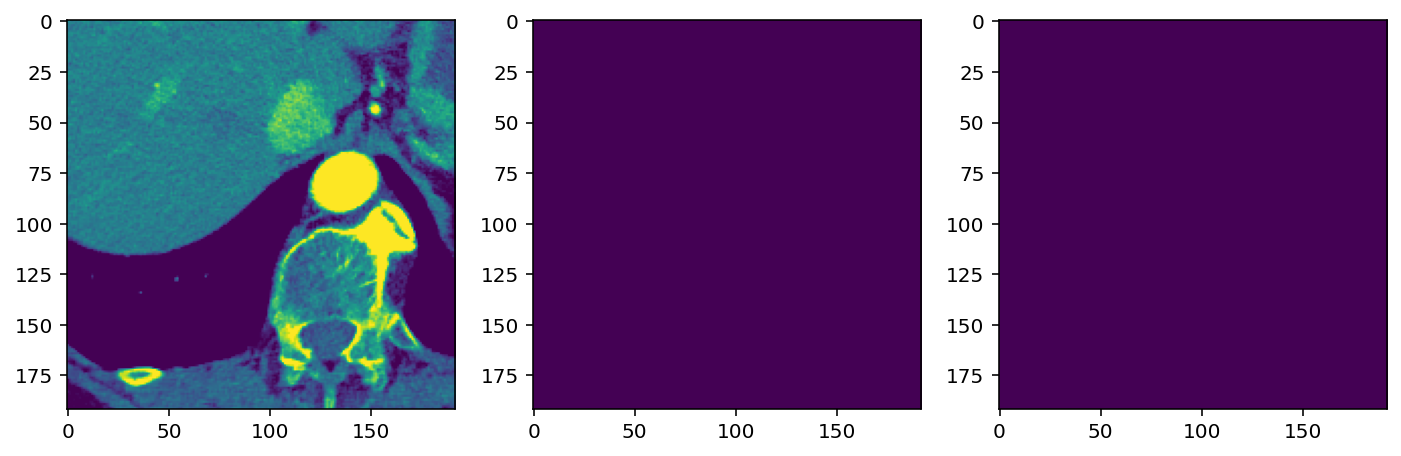

torch.Size([3, 32, 1, 192, 192])
torch.Size([3, 32, 1, 192, 192])


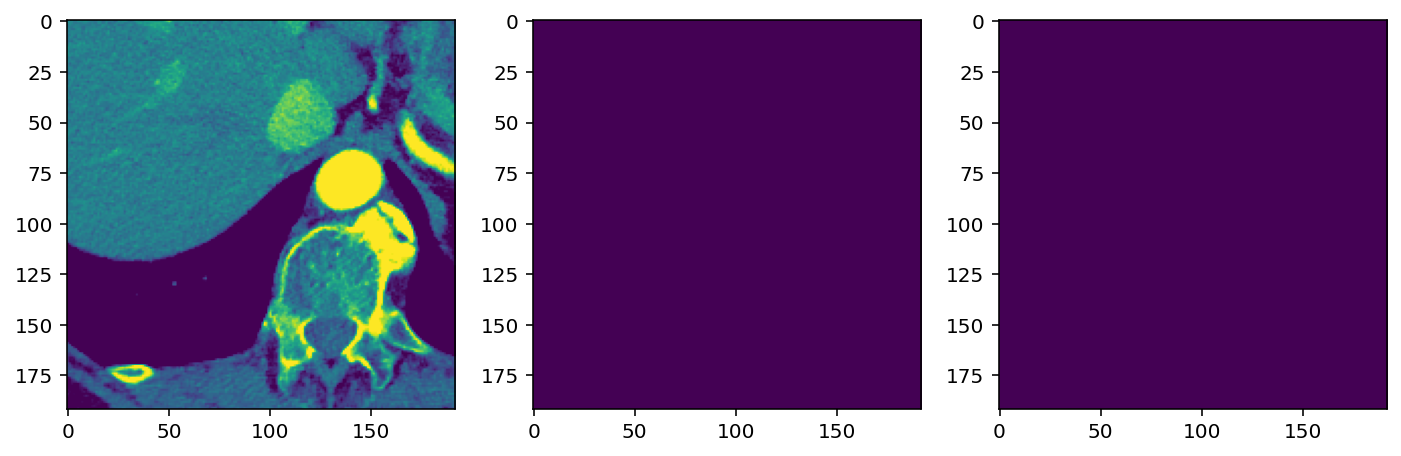

torch.Size([3, 32, 1, 192, 192])
torch.Size([3, 32, 1, 192, 192])


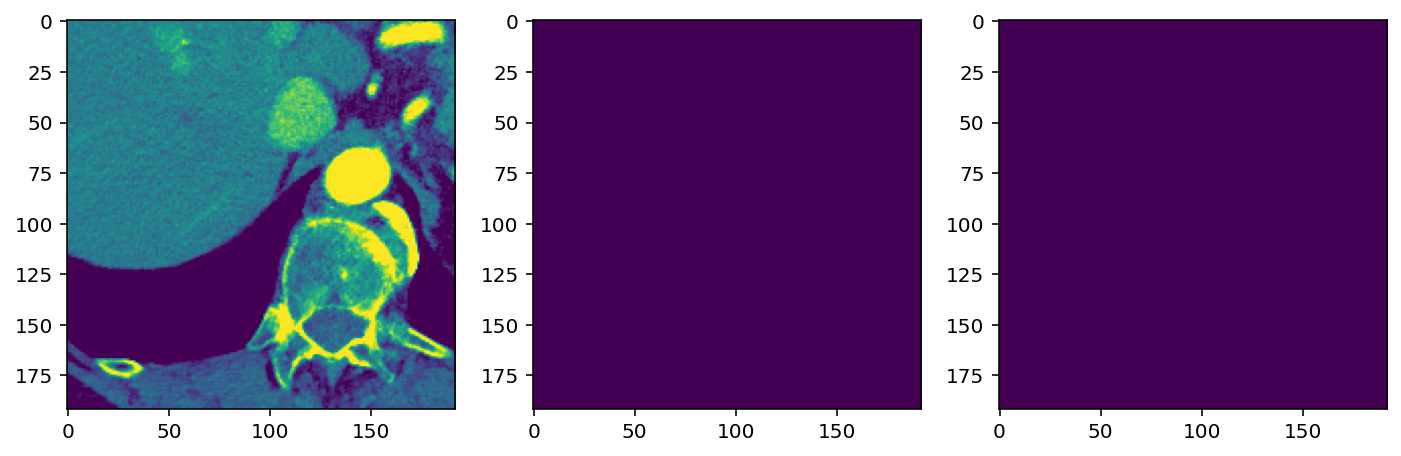

torch.Size([3, 32, 1, 192, 192])
torch.Size([3, 32, 1, 192, 192])


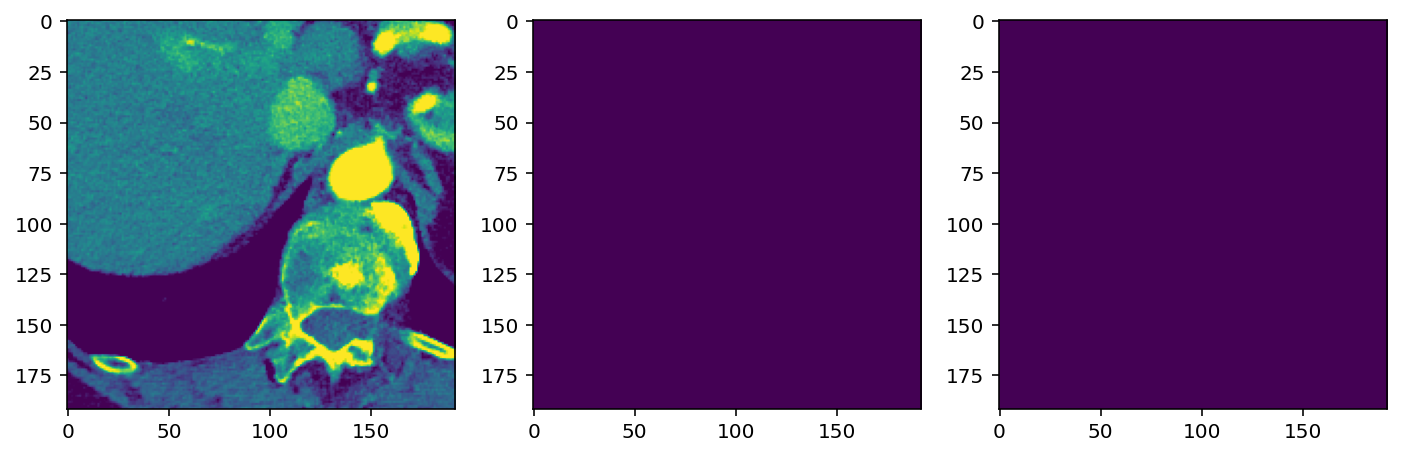

torch.Size([3, 32, 1, 192, 192])
torch.Size([3, 32, 1, 192, 192])


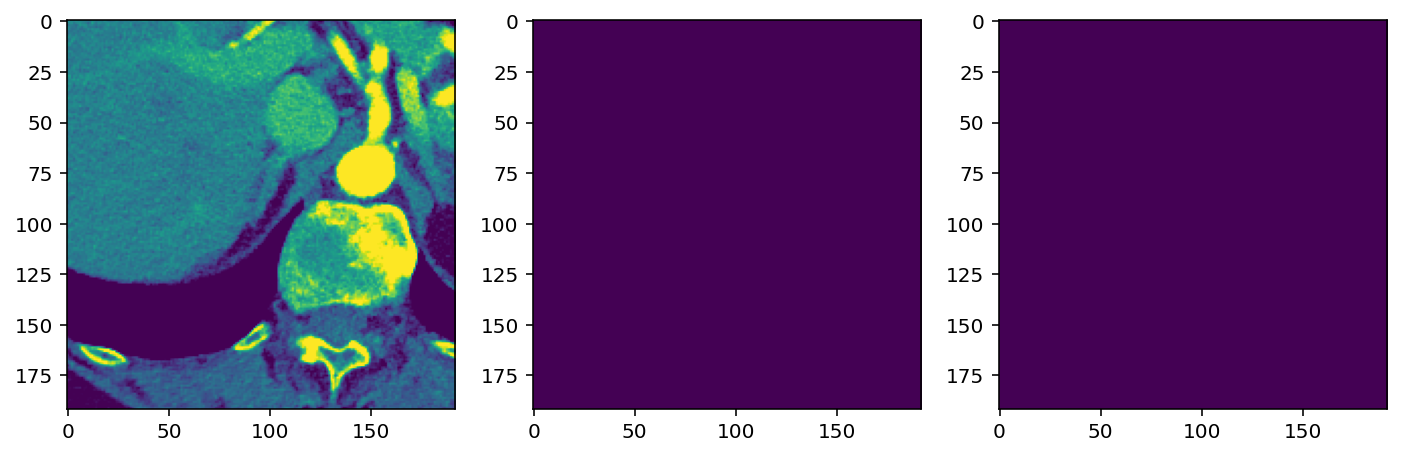

In [25]:
##input과 label이 맞나 확인
imagesa = next(iter(train_loader))
images=np.transpose(imagesa['image'],(0,4,1,2,3))
labels=np.transpose(imagesa['label'],(0,4,1,2,3))
for i in range(5):
    print(images.shape)
    print(labels.shape)
    plt.figure(figsize=(16,18))
    plt.subplot(1,4,1)
    plt.imshow(images[0][i][0])
    plt.subplot(1,4,2)
    plt.imshow(labels[0][i][0])
    plt.subplot(1,4,3)
    plt.imshow(labels[0][i][0])
#     plt.subplot(1,4,4)
#     plt.imshow(a[0][i])
    plt.show()
    

In [38]:
def compute_per_channel_dice(input, target, epsilon=1e-5, ignore_index=None, weight=None):
    # assumes that input is a normalized probability
    # input and target shapes must match
    assert input.size() == target.size(), "'input' and 'target' must have the same shape"

    # mask ignore_index if present
    if ignore_index is not None:
        mask = target.clone().ne_(ignore_index)
        mask.requires_grad = False

        input = input * mask
        target = target * mask

    input = flatten(input)
    target = flatten(target)

    # Compute per channel Dice Coefficient
    intersect = (input * target).sum(-1)
    if weight is not None:
        intersect = weight * intersect

    denominator = (input + target).sum(-1)
    return 2. * intersect / denominator.clamp(min=epsilon)

def flatten(tensor):
    """Flattens a given tensor such that the channel axis is first.
    The shapes are transformed as follows:
       (N, C, D, H, W) -> (C, N * D * H * W)
    """
    C = tensor.size(1)
    # new axis order
    axis_order = (1, 0) + tuple(range(2, tensor.dim()))
    # Transpose: (N, C, D, H, W) -> (C, N, D, H, W)
    transposed = tensor.permute(axis_order).contiguous()
    # Flatten: (C, N, D, H, W) -> (C, N * D * H * W)
    return transposed.view(C, -1)

class DiceLoss(nn.Module):
    """Computes Dice Loss, which just 1 - DiceCoefficient described above.
    Additionally allows per-class weights to be provided.
    """

    def __init__(self, epsilon=1e-5, weight=None, ignore_index=None, sigmoid_normalization=True,
                 skip_last_target=False):
        super(DiceLoss, self).__init__()
        if isinstance(weight, list):
            weight = torch.Tensor(weight)
            
        self.epsilon = epsilon
        self.register_buffer('weight', weight)
        self.ignore_index = ignore_index

        if sigmoid_normalization:
            self.normalization = nn.Sigmoid()
        else:
            self.normalization = nn.Softmax(dim=1)
        # if True skip the last channel in the target
        self.skip_last_target = skip_last_target

    def forward(self, input, target):
        # get probabilities from logits

        input = self.normalization(input)
        if self.weight is not None:
            weight = Variable(self.weight, requires_grad=False).to(input.device)
        else:
            weight = None

        if self.skip_last_target:
            target = target[:, :-1, ...]

        per_channel_dice = compute_per_channel_dice(input, target, epsilon=self.epsilon, ignore_index=self.ignore_index, weight=weight)
        # Average the Dice score across all channels/classes
        return torch.mean(1. - per_channel_dice)

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

In [ ]:
import torch
import torch.nn as nn


class VoxRes(nn.Module):
    """
    VoxRes module
    """
    def __init__(self, in_channel):
        super(VoxRes, self).__init__()
        self.block = nn.Sequential(
            nn.BatchNorm3d(in_channel), nn.ReLU(),
            nn.Conv3d(in_channel, in_channel, kernel_size=3, padding=1),
            nn.BatchNorm3d(in_channel), nn.ReLU(),
            nn.Conv3d(in_channel, in_channel, kernel_size=3, padding=1)
            )

    def forward(self, x):
        return self.block(x)+x
    
    
class VoxResNet(nn.Module):
    """
    Main model
    """
    def __init__(self, in_channels, num_class):
        super(VoxResNet, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv3d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32), nn.ReLU(),
            nn.Conv3d(32, 32, kernel_size=3, padding=1)
            )
        
        self.conv2 = nn.Sequential(
            nn.BatchNorm3d(32), nn.ReLU(),
            nn.Conv3d(32, 64, kernel_size=3, stride=(1, 2, 2), padding=1),
            VoxRes(64),
            VoxRes(64)
            )

        self.conv3 = nn.Sequential(
            nn.BatchNorm3d(64), nn.ReLU(),
            nn.Conv3d(64, 64, kernel_size=3, stride=(1, 2, 2), padding=1),
            VoxRes(64),
            VoxRes(64)
            )
        
        self.conv4 = nn.Sequential(
            nn.BatchNorm3d(64), nn.ReLU(),
            nn.Conv3d(64, 64, kernel_size=3, stride=(1, 2, 2), padding=1),
            VoxRes(64),
            VoxRes(64)
            )
        
        self.deconv_c1 = nn.Sequential(
            nn.ConvTranspose3d(32, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1)),
            nn.Conv3d(32, num_class, kernel_size=1))
        
        self.deconv_c2 = nn.Sequential(
            nn.ConvTranspose3d(64, 64, kernel_size=(1, 2, 2), stride=(1, 2, 2)),
            nn.Conv3d(64, num_class, kernel_size=1))
        
        self.deconv_c3 = nn.Sequential(
            nn.ConvTranspose3d(64, 64, kernel_size=(1, 4, 4), stride=(1, 4, 4)),
            nn.Conv3d(64, num_class, kernel_size=1))
        
        self.deconv_c4 = nn.Sequential(
            nn.ConvTranspose3d(64, 64, kernel_size=(1, 8, 8), stride=(1, 8, 8)),
            nn.Conv3d(64, num_class, kernel_size=1))

    def forward(self, x):
        out1 = self.conv1(x)
        out2 = self.conv2(out1)
        out3 = self.conv3(out2)
        out4 = self.conv4(out3)
        
        c1 = self.deconv_c1(out1)
        c2 = self.deconv_c2(out2)
        c3 = self.deconv_c3(out3)
        c4 = self.deconv_c4(out4)
        
        return c1+c2+c3+c4

In [ ]:
import segmentation_models_pytorch as smp
model = smp.FPN(
    encoder_name="resnext50_32x4d",# choose encoder, e.g. mobilenet_v2 or efficientnet-b7 resnext101_32x8d,timm-res2net101_26w_4s     # use `imagenet` pre-trained weights for encoder initialization 
    encoder_weights="imagenet",
    in_channels=64,
    # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2,                      # model output channels (number of classes in your dataset)
)

In [ ]:
model = VoxResNet(64,64)

In [24]:
from monai.losses import DiceCELoss
from monai.networks.nets import UNETR

In [25]:
model = UNETR(
    in_channels=1,
    out_channels=3,
    img_size=(192,192,32),
    feature_size=48,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
)

In [26]:
import torch.optim as optim

# criterion=smp.utils.losses.DiceLoss()
# criterion =  DiceLoss(sigmoid_normalization=True)

criterion = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

# optimizer = optim.Adam(model.parameters(),lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [27]:
sum([param.nelement() for param in model.parameters()])

112419795

In [28]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
    
device

'cuda'

In [ ]:
model

In [ ]:
logits.shape

In [29]:
from monai.inferers import sliding_window_inference

  0%|          | 0/100 [00:00<?, ?it/s]

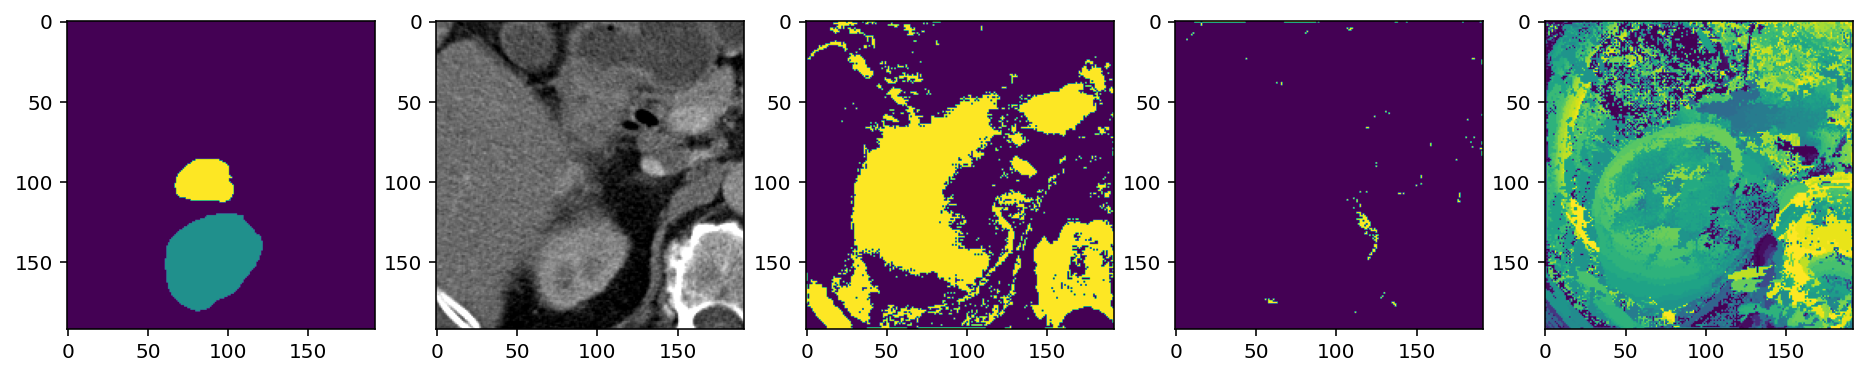

Epoch: 0 	Training Loss: 1.164390 


  0%|          | 0/100 [00:00<?, ?it/s]

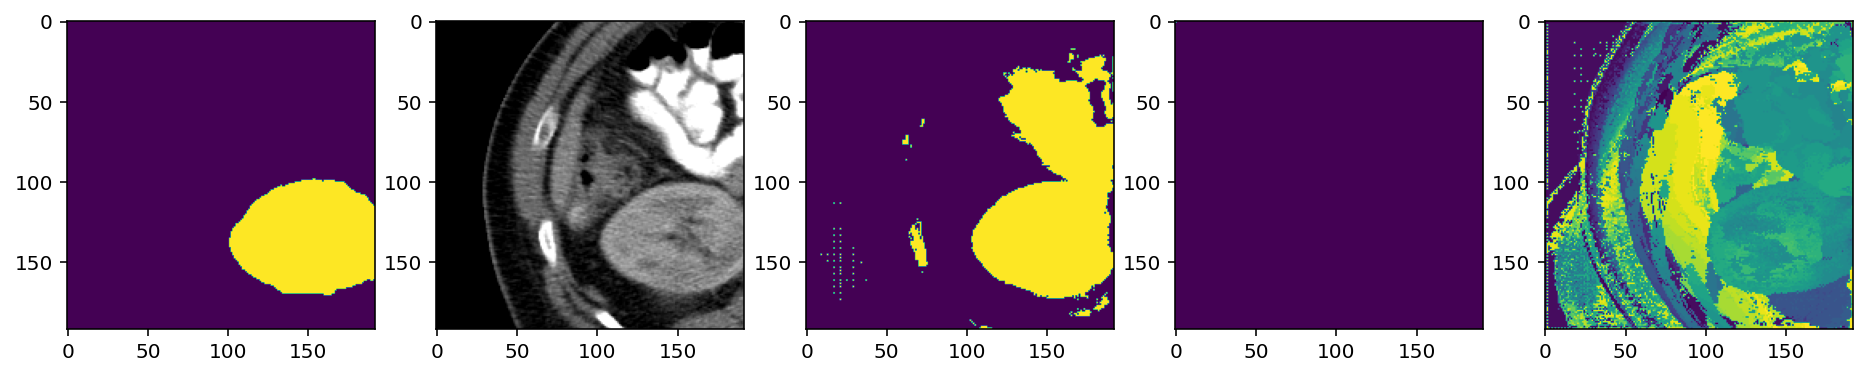

Epoch: 1 	Training Loss: 0.938485 


  0%|          | 0/100 [00:00<?, ?it/s]

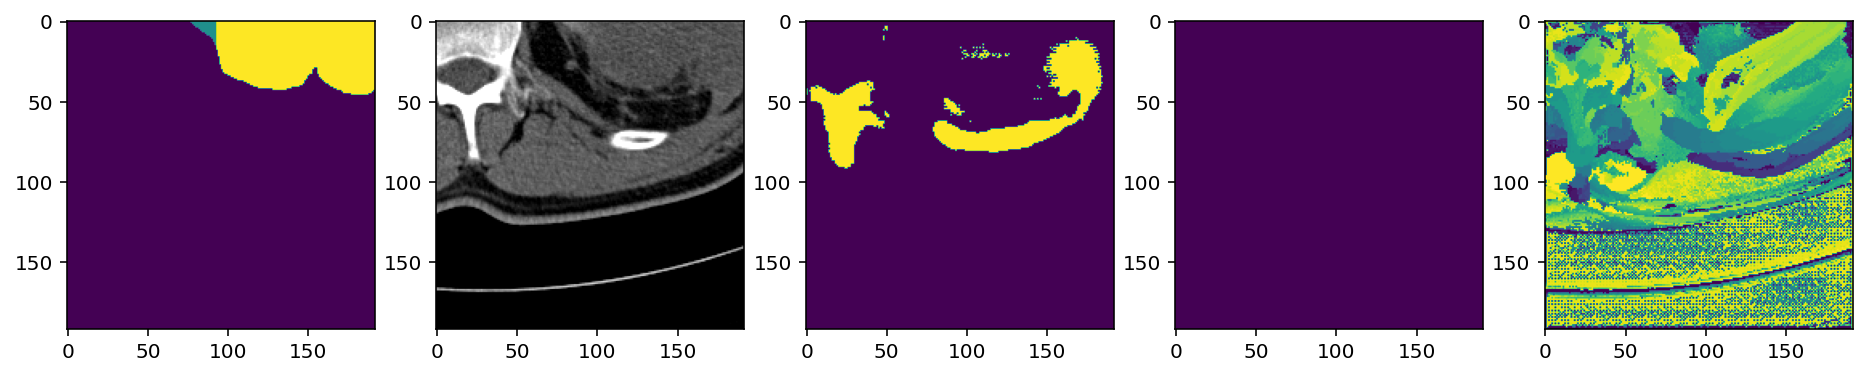

Epoch: 2 	Training Loss: 0.857953 


  0%|          | 0/100 [00:00<?, ?it/s]

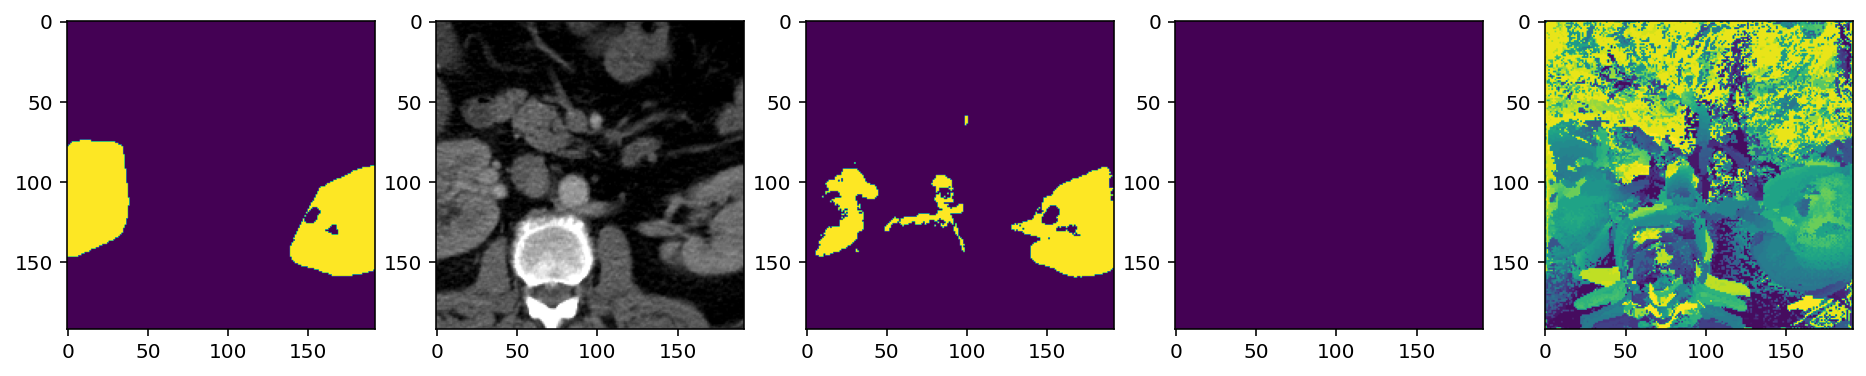

Epoch: 3 	Training Loss: 0.795383 


  0%|          | 0/100 [00:00<?, ?it/s]

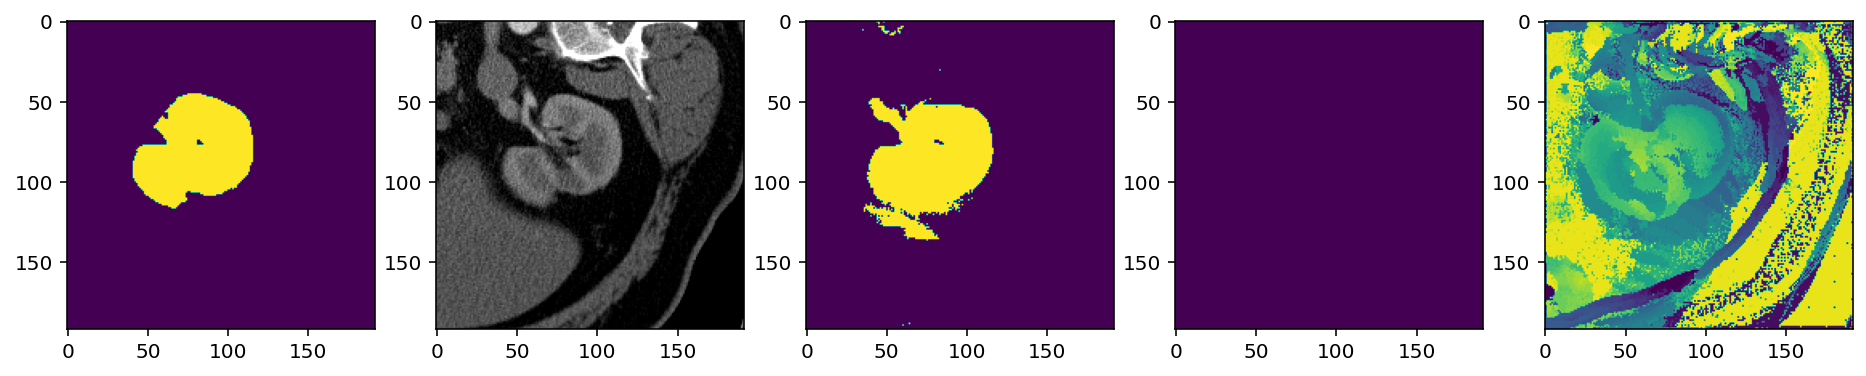

Epoch: 4 	Training Loss: 0.733672 


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
n_epochs = 500
cnt =0
valid_loss_min = np.Inf # track change in validation loss

# keep track of training and validation loss
train_loss = torch.zeros(n_epochs)
valid_loss = torch.zeros(n_epochs)

model.to(device)
for e in range(0, n_epochs):

   
    ###################
    # train the model #
    ###################
    model.train()
    for data in tqdm(train_loader):
        # move tensors to GPU if CUDA is available
        data, labels = data["image"].to(device), data["label"].to(device) #cpu에 있는 데이터를 gpu에 보냄
        
        # clear the gradients of all optimized variables
#         print(data.shape)
#         break
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        logits = model(data)
#         print(labels.shape)
        # calculate the batch loss
        loss = criterion(logits, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss[e] += loss.item()

        
#         z=logits.detach().cpu().numpy()
#         z = z.astype(np.uint8)
        cnt = cnt+1
#         torch.Size([3, 3, 80, 80, 16])
        if cnt %100==0:
            val_outputs = sliding_window_inference(
            data, (192, 192, 32), 4, model, overlap=0.8
            )
#             print(val_outputs.shape)
#             [3, 32, 1, 192, 192]
            val_outputs=np.transpose(val_outputs.detach().cpu(),(0,4,1,2,3))
            logits=np.transpose(logits.detach().cpu(),(0,4,1,2,3))
#             z= logits[0][0][size-1].detach().cpu().numpy()
#             z = z.astype(np.uint8)
            labels=np.transpose(labels.detach().cpu(),(0,4,1,2,3))
#             labels=np.transpose(labels.detach().cpu(),(0,1,4,2,3))
            dataa=np.transpose(data.detach().cpu(),(0,4,1,2,3))
#             b=logits.detach().cpu()
            logits = logits.sigmoid()
            logits = mask_binarization(logits.detach().cpu(), 0.5)
#             val_outputs= mask_binarization(val_outputs, 0.5)
            # y=torch.squeeze(labels[0])
#             y=logits[0][size-1].detach().cpu().numpy()
            y=logits
            dd=dataa[0][15]
        
            x=labels[0][15].detach().cpu().numpy()
#             print(dd.shape)
            #y=labels[0].numpy()
            plt.figure(figsize=(16,18))
            plt.subplot(1,5,1)
            plt.imshow(x[0])
            plt.subplot(1,5,2)
            plt.imshow(dd[0],cmap='gray')
            plt.subplot(1,5,3)
            plt.imshow(y[0][15][1])
            plt.subplot(1,5,4)
            plt.imshow(y[0][15][2])
            plt.subplot(1,5,5)
            plt.imshow(torch.argmax(val_outputs, dim=1)[0][1])
            plt.show()
 
    
    train_loss[e] /= len(train_loader)
    scheduler.step()
        
        
    ######################    
    # validate the model #
    ######################
#     with torch.no_grad(): 
#         model.eval()
#         for data in tqdm(val_loader):
#             # move tensors to GPU if CUDA is available
#             data, labels = data["image"].to(device), data["label"].to(device) #cpu에 있는 데이터를 gpu에 보냄
        
#             # forward pass: compute predicted outputs by passing inputs to the model
#             logits = model(data)
#             # calculate the batch loss
#             loss = criterion(logits, labels)
#             # update average validation loss 
#             valid_loss[e] += loss.item()

    
    # calculate average losses
#     valid_loss[e] /= len(val_loader)
    torch.save(model.state_dict(), 'model_2(100,50).pt')
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} '.format(
        e, train_loss[e]))
    
#     # save model if validation loss has decreased
#     if valid_loss[e] <= valid_loss_min:
#         print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
#         valid_loss_min,
#         valid_loss[e]))
#         torch.save(model.state_dict(), 'model_2(100,50).pt')
#         valid_loss_min = valid_loss[e]
        
        

In [ ]:
logits.shape

# [4, 2, 512, 512, 16]

In [ ]:
model.load_state_dict(torch.load('model_2(100,50).pt'))

In [ ]:
class TestMyDataset(torch.utils.data.Dataset):
    def __init__(self, x_dir,transform=None):
        super().__init__()
        self.transform = transform
        self.x_img = x_dir
     

    def __len__(self):
        return len(self.x_img)

    def __getitem__(self, idx):
        x_img = self.x_img[idx]
        # Read an image with OpenCV
        x_img = dcm.dcmread(x_img)
        x_img=read_dicom(x_img,500,50)
        x_img=np.transpose(x_img,(2,0,1))
        x_img=x_img.astype(np.float32)
        
       
        return x_img

In [ ]:
test_path=sorted(glob.glob( "./test/DICOM/**/*.dcm",recursive=True ))

In [ ]:
test_dataset = TestMyDataset(test_path)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1,shuffle=False)

In [ ]:
def mask_binarization(mask, threshold=None):
    if threshold is None:
        threshold = 0.5

    if isinstance(mask, np.ndarray):
        mask_binarized = (mask > threshold).astype(np.uint8)
    
    elif isinstance(mask, torch.Tensor):
        zeros = torch.zeros_like(mask)
        ones = torch.ones_like(mask)
        
        mask_binarized = torch.where(mask > threshold, ones, zeros)
    
    return mask_binarized

In [ ]:
def rle_encode(mask_image):
    pixels = mask_image.flatten()
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    return runs

def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)


preds_string=[]
preds = []
model.to(device)
cnt=0
t=0
for data in tqdm(test_loader):
    

    data= data.to(device)
#     data=data.unsqueeze(1)
    # forward pass: compute predicted outputs by passing inputs to the model
    pred = model(data)
    pred = pred.sigmoid()
    pred = mask_binarization(pred.detach().cpu(), 0.5)
    preds.append(pred.detach().cpu())
    
    # if cnt%64==0:
    #     y=preds[cnt][0]
    #     #y=torch.squeeze(0)
    #     y=y.numpy()
    #     x=data[0].detach().cpu().numpy()
    #     #y=labels[0].numpy()
    #     plt.figure(figsize=(16,18))
    #     plt.subplot(1,3,1)
    #     plt.imshow(x[0],cmap='gray')
    #     plt.subplot(1,3,2)
    #     plt.imshow(y[0])
    #     plt.subplot(1,3,3)
    #     plt.imshow(y[1])
    #     plt.show()
    # cnt= cnt+1
    
for i in tqdm(range(0, len(preds),64)):
  sample = preds[i:i+64]
  for c in range(2):
    for label_code in [1]:
      tmp=[]
      for s in sample:
        s = np.equal(s[0][c], label_code).flatten()*1
        tmp+=s.tolist()
      enc = rle_to_string(rle_encode(np.array(tmp)))
      preds_string.append(enc)


In [ ]:
sample_submission = pd.read_csv('./sample_submission.csv')
sample_submission['EncodedPixels'] = preds_string
sample_submission.to_csv('submission.csv', index=False)